##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Custom Federated Algorithms, Part 2: Implementing Federated Averaging

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_2"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.28.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.28.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/federated/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is the second part of a two-part series that demonstrates how to
implement custom types of federated algorithms in TFF using the
[Federated Core (FC)](../federated_core.md), which serves as a foundation for
the [Federated Learning (FL)](../federated_learning.md) layer (`tff.learning`).

We encourage you to first read the
[first part of this series](custom_federated_algorithms_1.ipynb), which
introduce some of the key concepts and programming abstractions used here.

This second part of the series uses the mechanisms introduced in the first part
to implement a simple version of federated training and evaluation algorithms.

We encourage you to review the
[image classification](federated_learning_for_image_classification.ipynb) and
[text generation](federated_learning_for_text_generation.ipynb) tutorials for a
higher-level and more gentle introduction to TFF's Federated Learning APIs, as
they will help you put the concepts we describe here in context.

## Before we start

Before we start, try to run the following "Hello World" example to make sure
your environment is correctly setup. If it doesn't work, please refer to the
[Installation](../install.md) guide for instructions.

In [2]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

In [3]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

# Must use the Python context because it
# supports tff.sequence_* intrinsics.
executor_factory = tff.framework.local_executor_factory(
    support_sequence_ops=True)
execution_context = tff.framework.ExecutionContext(
    executor_fn=executor_factory)
tff.framework.set_default_context(execution_context)

In [4]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

b'Hello, World!'

## Implementing Federated Averaging

As in
[Federated Learning for Image Classification](federated_learning_for_image_classification.ipynb),
we are going to use the MNIST example, but since this is intended as a low-level
tutorial, we are going to bypass the Keras API and `tff.simulation`, write raw
model code, and construct a federated data set from scratch.


### Preparing federated data sets

For the sake of a demonstration, we're going to simulate a scenario in which we
have data from 10 users, and each of the users contributes knowledge how to
recognize a different digit. This is about as
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)
as it gets.

First, let's load the standard MNIST data:

In [5]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [6]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

The data comes as Numpy arrays, one with images and another with digit labels, both
with the first dimension going over the individual examples. Let's write a
helper function that formats it in a way compatible with how we feed federated
sequences into TFF computations, i.e., as a list of lists - the outer list
ranging over the users (digits), the inner ones ranging over batches of data in
each client's sequence. As is customary, we will structure each batch as a pair
of tensors named `x` and `y`, each with the leading batch dimension. While at
it, we'll also flatten each image into a 784-element vector and rescale the
pixels in it into the `0..1` range, so that we don't have to clutter the model
logic with data conversions.

In [7]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100


def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

As a quick sanity check, let's look at the `Y` tensor in the last batch of data
contributed by the fifth client (the one corresponding to the digit `5`).

In [8]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

Just to be sure, let's also look at the image corresponding to the last element of that batch.

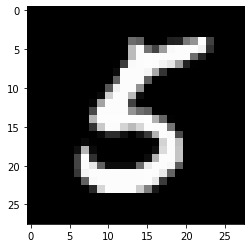

In [9]:
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()

### On combining TensorFlow and TFF

In this tutorial, for compactness we immediately decorate functions that
introduce TensorFlow logic with `tff.tf_computation`. However, for more complex
logic, this is not the pattern we recommend. Debugging TensorFlow can already be
a challenge, and debugging TensorFlow after it has been fully serialized and
then re-imported necessarily loses some metadata and limits interactivity,
making debugging even more of a challenge.

Therefore, **we strongly recommend writing complex TF logic as stand-alone
Python functions** (that is, without `tff.tf_computation` decoration). This way
the TensorFlow logic can be developed and tested using TF best practices and
tools (like eager mode), before serializing the computation for TFF (e.g., by invoking `tff.tf_computation` with a Python function as the argument).

### Defining a loss function

Now that we have the data, let's define a loss function that we can use for
training. First, let's define the type of input as a TFF named tuple. Since the
size of data batches may vary, we set the batch dimension to `None` to indicate
that the size of this dimension is unknown.

In [10]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

You may be wondering why we can't just define an ordinary Python type. Recall
the discussion in [part 1](custom_federated_algorithms_1.ipynb), where we
explained that while we can express the logic of TFF computations using Python,
under the hood TFF computations *are not* Python. The symbol `BATCH_TYPE`
defined above represents an abstract TFF type specification. It is important to
distinguish this *abstract* TFF type from concrete Python *representation*
types, e.g., containers such as `dict` or `collections.namedtuple` that may be
used to represent the TFF type in the body of a Python function. Unlike Python,
TFF has a single abstract type constructor `tff.StructType` for tuple-like
containers, with elements that can be individually named or left unnamed. This
type is also used to model formal parameters of computations, as TFF
computations can formally only declare one parameter and one result - you will
see examples of this shortly.

Let's now define the TFF type of model parameters, again as a TFF named tuple of
*weights* and *bias*.

In [11]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)
print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


With those definitions in place, now we can define the loss for a given model, over a single batch. Note the usage of `@tf.function` decorator inside the `@tff.tf_computation` decorator. This allows us to write TF using Python like semantics even though were inside a `tf.Graph` context created by the `tff.tf_computation` decorator.

In [12]:
# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias'])
  return -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

As expected, computation `batch_loss` returns `float32` loss given the model and
a single data batch. Note how the `MODEL_TYPE` and `BATCH_TYPE` have been lumped
together into a 2-tuple of formal parameters; you can recognize the type of
`batch_loss` as `(<MODEL_TYPE,BATCH_TYPE> -> float32)`.

In [13]:
str(batch_loss.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>> -> float32)'

As a sanity check, let's construct an initial model filled with zeros and
compute the loss over the batch of data we visualized above.

In [14]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025851

Note that we feed the TFF computation with the initial model defined as a
`dict`, even though the body of the Python function that defines it consumes
model parameters as `model['weight']` and `model['bias']`. The arguments of the call
to `batch_loss` aren't simply passed to the body of that function.


What happens when we invoke `batch_loss`?
The Python body of `batch_loss` has already been traced and serialized  in the above cell where it was defined.  TFF acts as the caller to `batch_loss`
at the computation definition time, and as the target of invocation at the time
`batch_loss` is invoked. In both roles, TFF serves as the bridge between TFF's
abstract type system and Python representation types. At the invocation time,
TFF will accept most standard Python container types (`dict`, `list`, `tuple`,
`collections.namedtuple`, etc.) as concrete representations of abstract TFF
tuples. Also, although as noted above, TFF computations formally only accept a
single parameter, you can use the familiar Python call syntax with positional
and/or keyword arguments in case where the type of the parameter is a tuple - it
works as expected.

### Gradient descent on a single batch

Now, let's define a computation that uses this loss function to perform a single
step of gradient descent. Note how in defining this function, we use
`batch_loss` as a subcomponent. You can invoke a computation constructed with
`tff.tf_computation` inside the body of another computation, though typically
this is not necessary - as noted above, because serialization looses some
debugging information, it is often preferable for more complex computations to
write and test all the TensorFlow without the `tff.tf_computation` decorator.

In [15]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars

  return _train_on_batch(model_vars, batch)

In [16]:
str(batch_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>,learning_rate=float32> -> <weights=float32[784,10],bias=float32[10]>)'

When you invoke a Python function decorated with `tff.tf_computation` within the
body of another such function, the logic of the inner TFF computation is
embedded (essentially, inlined) in the logic of the outer one. As noted above,
if you are writing both computations, it is likely preferable to make the inner
function (`batch_loss` in this case) a regular Python or `tf.function` rather
than a `tff.tf_computation`. However, here we illustrate that calling one
`tff.tf_computation` inside another basically works as expected. This may be
necessary if, for example, you do not have the Python code defining
`batch_loss`, but only its serialized TFF representation.

Now, let's apply this function a few times to the initial model to see whether
the loss decreases.

In [17]:
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [18]:
losses

[0.19690023, 0.13176313, 0.10113225, 0.08273812, 0.070301384]

### Gradient descent on a sequence of local data

Now, since `batch_train` appears to work, let's write a similar training
function `local_train` that consumes the entire sequence of all batches from one
user instead of just a single batch. The new computation will need to now
consume `tff.SequenceType(BATCH_TYPE)` instead of `BATCH_TYPE`.

In [19]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

  @tff.tf_computation(LOCAL_DATA_TYPE, tf.float32)
  def _insert_learning_rate_to_sequence(dataset, learning_rate):
    return dataset.map(lambda x: (x, learning_rate))

  batches_with_learning_rate = _insert_learning_rate_to_sequence(all_batches, learning_rate)

  # Mapping function to apply to each batch.
  @tff.federated_computation(MODEL_TYPE, batches_with_learning_rate.type_signature.element)
  def batch_fn(model, batch_with_lr):
    batch, lr = batch_with_lr
    return batch_train(model, batch, lr)

  return tff.sequence_reduce(batches_with_learning_rate, initial_model, batch_fn)

In [20]:
str(local_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,learning_rate=float32,all_batches=<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

There are quite a few details buried in this short section of code, let's go
over them one by one.

First, while we could have implemented this logic entirely in TensorFlow,
relying on `tf.data.Dataset.reduce` to process the sequence similarly to how
we've done it earlier, we've opted this time to express the logic in the glue
language, as a `tff.federated_computation`. We've used the federated operator
`tff.sequence_reduce` to perform the reduction.

The operator `tff.sequence_reduce` is used similarly to
`tf.data.Dataset.reduce`. You can think of it as essentially the same as
`tf.data.Dataset.reduce`, but for use inside federated computations, which as
you may remember, cannot contain TensorFlow code. It is a template operator with
a formal parameter 3-tuple that consists of a *sequence* of `T`-typed elements,
the initial state of the reduction (we'll refer to it abstractly as *zero*) of
some type `U`, and the *reduction operator* of type `(<U,T> -> U)` that alters the
state of the reduction by processing a single element. The result is the final
state of the reduction, after processing all elements in a sequential order. In
our example, the state of the reduction is the model trained on a prefix of the
data, and the elements are data batches.

Second, note that we have again used one computation (`batch_train`) as a
component within another (`local_train`), but not directly. We can't use it as a
reduction operator because it takes an additional parameter - the learning rate.
To resolve this, we define an embedded federated computation `batch_fn` that
binds to the `local_train`'s parameter `learning_rate` in its body. It is
allowed for a child computation defined this way to capture a formal parameter
of its parent as long as the child computation is not invoked outside the body
of its parent. You can think of this pattern as an equivalent of
`functools.partial` in Python.

The practical implication of capturing `learning_rate` this way is, of course,
that the same learning rate value is used across all batches.

Now, let's try the newly defined local training function on the entire sequence
of data from the same user who contributed the sample batch (digit `5`).

In [21]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

Did it work? To answer this question, we need to implement evaluation.

### Local evaluation

Here's one way to implement local evaluation by adding up the losses across all data
batches (we could have just as well computed the average; we'll leave it as an
exercise for the reader).

In [22]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):

  @tff.tf_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
  def _insert_model_to_sequence(model, dataset):
    return dataset.map(lambda x: (model, x))

  model_plus_data = _insert_model_to_sequence(model, all_batches)

  @tff.tf_computation(tf.float32, batch_loss.type_signature.result)
  def tff_add(accumulator, arg):
    return accumulator + arg

  return tff.sequence_reduce(
      tff.sequence_map(
          batch_loss,
          model_plus_data), 0., tff_add)

In [23]:
str(local_eval.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,all_batches=<x=float32[?,784],y=int32[?]>*> -> float32)'

Again, there are a few new elements illustrated by this code, let's go over them
one by one.

First, we have used two new federated operators for processing sequences:
`tff.sequence_map` that takes a *mapping function* `T->U` and a *sequence* of
`T`, and emits a sequence of `U` obtained by applying the mapping function
pointwise, and `tff.sequence_sum` that just adds all the elements. Here, we map
each data batch to a loss value, and then add the resulting loss values to
compute the total loss.

Note that we could have again used `tff.sequence_reduce`, but this wouldn't be
the best choice - the reduction process is, by definition, sequential, whereas
the mapping and sum can be computed in parallel. When given a choice, it's best
to stick with operators that don't constrain implementation choices, so that
when our TFF computation is compiled in the future to be deployed to a specific
environment, one can take full advantage of all potential opportunities for a
faster, more scalable, more resource-efficient execution.

Second, note that just as in `local_train`, the component function we need
(`batch_loss`) takes more parameters than what the federated operator
(`tff.sequence_map`) expects, so we again define a partial, this time inline by
directly wrapping a `lambda` as a `tff.federated_computation`. Using wrappers
inline with a function as an argument is the recommended way to use
`tff.tf_computation` to embed TensorFlow logic in TFF.

Now, let's see whether our training worked.

In [24]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[5]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[5]))

initial_model loss = 23.025854
locally_trained_model loss = 0.43484688


Indeed, the loss decreased. But what happens if we evaluated it on another
user's data?

In [25]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[0]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 23.025854
locally_trained_model loss = 74.50075


As expected, things got worse. The model was trained to recognize `5`, and has
never seen a `0`. This brings the question - how did the local training impact
the quality of the model from the global perspective?

### Federated evaluation

This is the point in our journey where we finally circle back to federated types
and federated computations - the topic that we started with. Here's a pair of
TFF types definitions for the model that originates at the server, and the data
that remains on the clients.

In [26]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

With all the definitions introduced so far, expressing federated evaluation in
TFF is a one-liner - we distribute the model to clients, let each client invoke
local evaluation on its local portion of data, and then average out the loss.
Here's one way to write this.

In [27]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model),  data]))

We've already seen examples of `tff.federated_mean` and `tff.federated_map`
in simpler scenarios, and at the intuitive level, they work as expected, but
there's more in this section of code than meets the eye, so let's go over it
carefully.

First, let's break down the *let each client invoke local evaluation on its
local portion of data* part. As you may recall from the preceding sections,
`local_eval` has a type signature of the form `(<MODEL_TYPE, LOCAL_DATA_TYPE> ->
float32)`.

The federated operator `tff.federated_map` is a template that accepts as a
parameter a 2-tuple that consists of the *mapping function* of some type `T->U`
and a federated value of type `{T}@CLIENTS` (i.e., with member constituents of
the same type as the parameter of the mapping function), and returns a result of
type `{U}@CLIENTS`.

Since we're feeding `local_eval` as a mapping function to apply on a per-client
basis, the second argument should be of a federated type `{<MODEL_TYPE,
LOCAL_DATA_TYPE>}@CLIENTS`, i.e., in the nomenclature of the preceding sections,
it should be a federated tuple. Each client should hold a full set of arguments
for `local_eval` as a member consituent. Instead, we're feeding it a 2-element
Python `list`. What's happening here?

Indeed, this is an example of an *implicit type cast* in TFF, similar to
implicit type casts you may have encountered elsewhere, e.g., when you feed an
`int` to a function that accepts a `float`. Implicit casting is used scarcily at
this point, but we plan to make it more pervasive in TFF as a way to minimize
boilerplate.

The implicit cast that's applied in this case is the equivalence between
federated tuples of the form `{<X,Y>}@Z`, and tuples of federated values
`<{X}@Z,{Y}@Z>`. While formally, these two are different type signatures,
looking at it from the programmers's perspective, each device in `Z` holds two
units of data `X` and `Y`. What happens here is not unlike `zip` in Python, and
indeed, we offer an operator `tff.federated_zip` that allows you to perform such
conversions explicity. When the `tff.federated_map` encounters a tuple as a
second argument, it simply invokes `tff.federated_zip` for you.

Given the above, you should now be able to recognize the expression
`tff.federated_broadcast(model)` as representing a value of TFF type
`{MODEL_TYPE}@CLIENTS`, and `data` as a value of TFF type
`{LOCAL_DATA_TYPE}@CLIENTS` (or simply `CLIENT_DATA_TYPE`), the two getting
filtered together through an implicit `tff.federated_zip` to form the second
argument to `tff.federated_map`.

The operator `tff.federated_broadcast`, as you'd expect, simply transfers data
from the server to the clients.

Now, let's see how our local training affected the average loss in the system.

In [28]:
print('initial_model loss =', federated_eval(initial_model,
                                             federated_train_data))
print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 23.025852
locally_trained_model loss = 54.432625


Indeed, as expected, the loss has increased. In order to improve the model for
all users, we'll need to train in on everyone's data.

### Federated training

The simplest way to implement federated training is to locally train, and then
average the models. This uses the same building blocks and patters we've already
discussed, as you can see below.

In [29]:
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

Note that in the full-featured implementation of Federated Averaging provided by
`tff.learning`, rather than averaging the models, we prefer to average model
deltas, for a number of reasons, e.g., the ability to clip the update norms,
for compression, etc.

Let's see whether the training works by running a few rounds of training and
comparing the average loss before and after.

In [30]:
model = initial_model
learning_rate = 0.1
for round_num in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  loss = federated_eval(model, federated_train_data)
  print('round {}, loss={}'.format(round_num, loss))

round 0, loss=21.60552215576172
round 1, loss=20.365678787231445
round 2, loss=19.27480125427246
round 3, loss=18.311111450195312
round 4, loss=17.45725440979004


For completeness, let's now also run on the test data to confirm that our model
generalizes well.

In [31]:
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))

initial_model test loss = 22.795593
trained_model test loss = 17.278767


This concludes our tutorial.

Of course, our simplified example doesn't reflect a number of things you'd need
to do in a more realistic scenario - for example, we haven't computed metrics
other than loss. We encourage you to study
[the implementation](https://github.com/tensorflow/federated/blob/main/tensorflow_federated/python/learning/federated_averaging.py)
of federated averaging in `tff.learning` as a more complete example, and as a
way to demonstrate some of the coding practices we'd like to encourage.